**Table of Contents** <br>
* [1. Import Libraries and Dataset](#importld)
* [2. Perspectives](#perspectives)

<hr>
<a class="anchor" id="importld">
    
# 1. Import Libraries and Dataset
    
</a>

In [1]:
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

sns.set()

In [2]:
df = pd.read_csv('datasets/data_clean.csv')

<hr>
<a class="anchor" id="perspectives">
    
# 2. Perspectives
    
</a>

In [3]:
df.head()

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,CUI_diversity,Night,Day,Dinner,Weekdays,Weekends,Age_Group,Asian,Western,Other
0,2360,18,2,5,1,0,1,DELIVERY,DIGI,0.00,...,1,0,0,2,0,2,<23,28.88,0.00,0.0
1,8670,17,2,2,2,0,1,DISCOUNT,DIGI,12.82,...,2,0,2,0,0,2,<23,6.39,12.82,0.0
2,4660,38,1,2,2,0,1,DISCOUNT,CASH,9.20,...,1,0,2,0,0,2,35+,0.00,9.20,0.0
3,4660,27,2,3,1,0,2,DELIVERY,DIGI,0.00,...,2,0,2,0,1,1,23-28,31.56,0.00,0.0
4,4660,20,2,5,0,0,2,-,DIGI,14.57,...,2,0,2,0,1,1,<23,40.87,14.57,0.0


In [4]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
       'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2',
       'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10',
       'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'Total_Orders',
       'Total_Spent', 'Spent_Per_Order', 'Items_Per_Order', 'Frequency',
       'Loyalty', 'Time_with_us', 'CUI_diversity', 'Night', 'Day', 'Dinner',
       'Weekdays', 'Weekends', 'Age_Group', 'Asian', 'Western', 'Other'],
      dtype='object')

In [5]:
# Split variables into perspectives
behavior_features = ['Total_Spent',
                     'Spent_Per_Order', 
                     'Loyalty', 
                     'Time_with_us']

time_features = ['Night', 'Day', 'Dinner']

preferences_features = ['Asian', 'Western', 'Other']

df_beh = df[behavior_features]
df_time = df[time_features]
df_pref = df[preferences_features]

# drop categorical and object columns to get means of each cluster
metric_variables = df.drop(columns=['customer_region', 'last_promo', 'payment_method', 'Age_Group']).columns

In [6]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [7]:
# Obtaining the R² scores for each cluster solution on predf_beh features
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_beh, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_beh, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.449049,0.019485,0.019485,0.019485,0.433222
3,0.658520,0.207104,0.078015,0.027223,0.641646
4,0.759488,0.213597,0.078830,0.042080,0.733720
5,0.808303,0.219752,0.359132,0.042342,0.792972
6,0.835166,0.427968,0.377566,0.042361,0.816196
7,0.859506,0.431080,0.378086,0.079631,0.839278
8,0.879611,0.431316,0.579816,0.080676,0.860169
9,0.894328,0.585128,0.579901,0.082948,0.878886


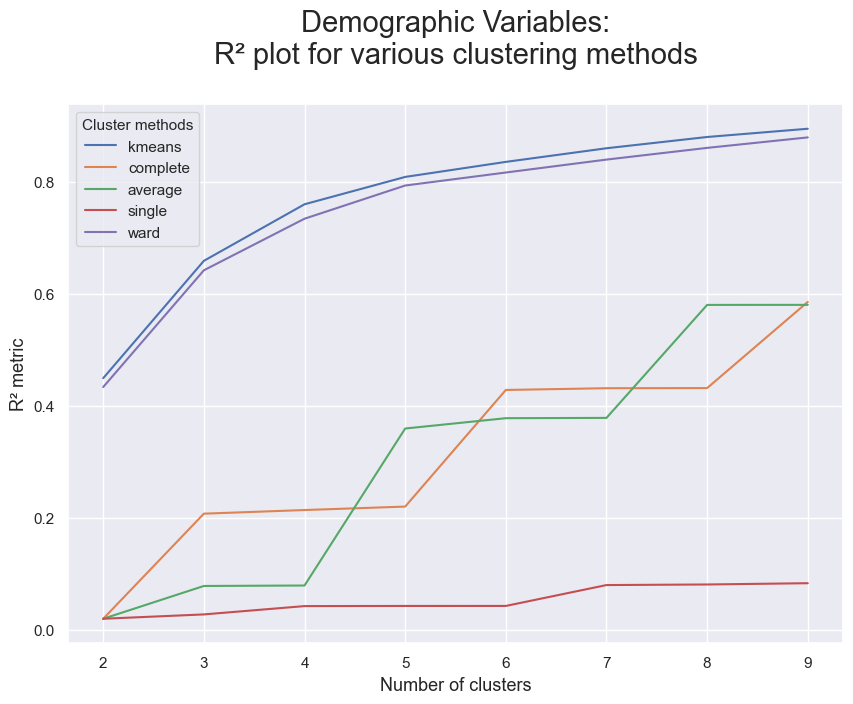

In [8]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

sns.axes_style("whitegrid")
plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.grid(True)
plt.show()

In [9]:
# Obtaining the R² scores for each cluster solution on time features
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_time, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_time, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.342915,0.038160,0.021694,0.005357,0.252727
3,0.458482,0.082594,0.049421,0.011288,0.382299
4,0.554535,0.288002,0.051136,0.018910,0.506916
5,0.614573,0.290767,0.181423,0.022727,0.573777
6,0.671147,0.321392,0.193982,0.039602,0.625142
7,0.710980,0.331183,0.195638,0.046158,0.676419
8,0.744411,0.332537,0.196175,0.048153,0.708535
9,0.765953,0.336607,0.205069,0.048344,0.728377


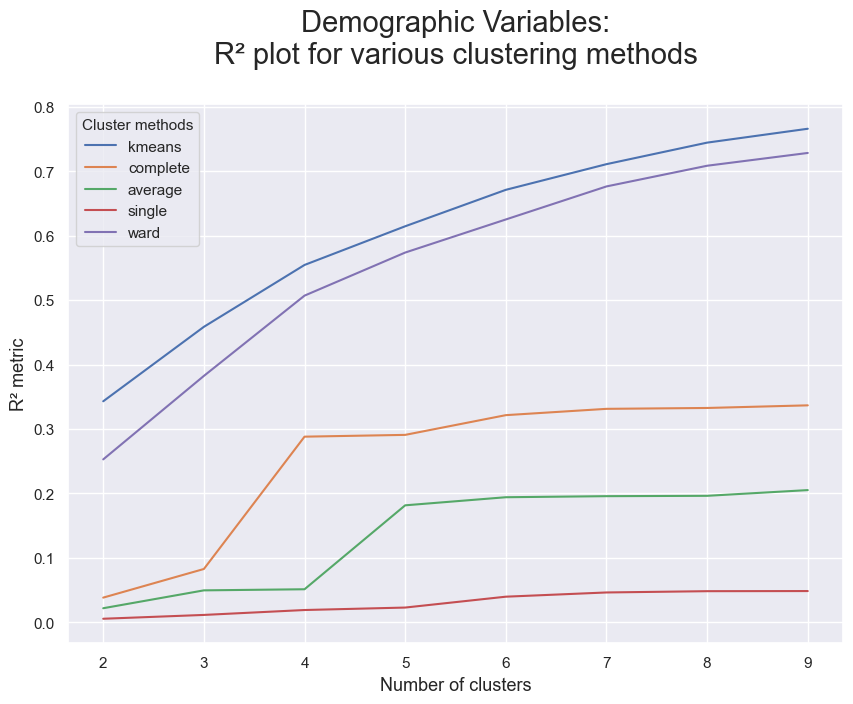

In [10]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.grid(True)
plt.show()

In [ ]:
# Obtaining the R² scores for each cluster solution on predf_pref features
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_pref, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_pref, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

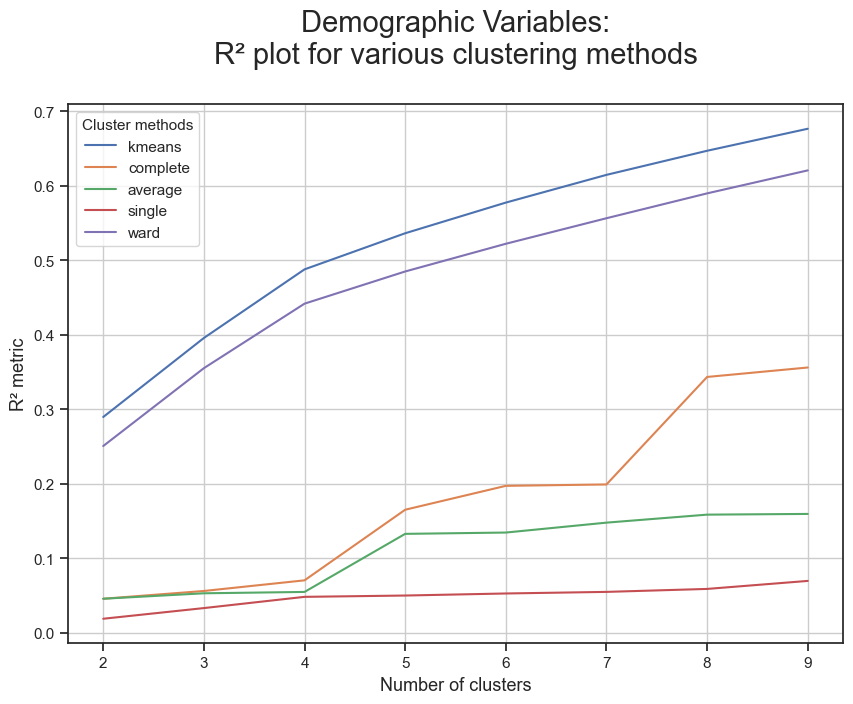

In [ ]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))


plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.grid(True)
plt.show()